# LoRA Generation

In [1]:
import torch
import itertools
from api.sd import *
from api.lora import *
from api.dataset import *
import bitsandbytes as bnb
from accelerate import Accelerator
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import clear_output
from diffusers.optimization import get_scheduler
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline

if torch.cuda.is_available(): torch.cuda.empty_cache()
clear_output()

### Constants

In [2]:
LR = 1e-4
EPOCHS = 100
LORA_RANK = 16
GRAD_AC_STEPS = 1
ADAM_EPSILON = 1e-8
BETAS = (0.9, 0.999)
LR__WARMUP_STEPS = 0
MIXED_PRECISION = None
ADAM_WEIGHT_DECAY = 1e-2

### Variables

In [3]:
accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRAD_AC_STEPS,
)

sd = SD(model_id=OFA)
sd.to(accelerator.device)

unet_lora_params, _ = inject_trainable_lora(sd.unet, r=LORA_RANK)
params_to_optimize = itertools.chain(*unet_lora_params)
optimizer = bnb.optim.AdamW8bit(params_to_optimize,
    lr=LR,
    betas=BETAS,
    eps=ADAM_EPSILON,
    weight_decay=ADAM_WEIGHT_DECAY,
)
clear_output()

### Dataset

In [4]:
BATCH_SIZE = 1
NUM_WORKERS = 1

PROMPT = "charachter laura"
IMG_DIR_PATH = f"{BASE_DIR}/laura/train"

train_dataset = CustomDataset(IMG_DIR_PATH, PROMPT)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)

### Training

In [5]:
TRAIN_STEPS = EPOCHS * len(train_data_loader) // GRAD_AC_STEPS

lr_scheduler = get_scheduler("constant",
    optimizer=optimizer,
    num_warmup_steps=LR__WARMUP_STEPS * GRAD_AC_STEPS,
    num_training_steps=EPOCHS * len(train_data_loader)
)

progress_bar = tqdm(range(TRAIN_STEPS), desc="Steps")
for _ in range(EPOCHS):
    sd.unet.train()
    train_epoch(sd, train_data_loader, accelerator, optimizer, lr_scheduler, progress_bar)

accelerator.wait_for_everyone()

Steps: 100%|██████████| 1500/1500 [05:16<00:00,  4.92it/s, loss=0.00796, lr=0.0001]

In [6]:
sd.save(accelerator, "lura_ofa")
accelerator.end_training()
clear_output()

### Inference

In [63]:
lora_pipe = DiffusionPipeline.from_pretrained(sd.model_id, torch_dtype=torch.float16)
lora_pipe.to("cuda")
lora_pipe.safety_checker = None

monkeypatch_or_replace_lora(lora_pipe.unet, torch.load(f"{BASE_DIR}/saved/lura_ofa.pt"))
clear_output()

In [113]:
SEED = 0
GUIDANCE = 3
LORA_SCALE_UNET = 0.8
LORA_PROMPT = 'character laura headshot weating a suit'

pipe_kwargs = {
    "num_inference_steps": 50,
    "guidance_scale": GUIDANCE,
    # "negative_prompt": "low resolution, ugly",
}

In [114]:
tune_lora_scale(lora_pipe.unet, LORA_SCALE_UNET)
lora_image = lora_pipe(LORA_PROMPT, **pipe_kwargs).images[0]
clear_output()

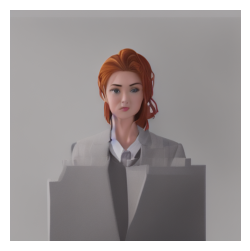

In [115]:
display([
    {
      "img": lora_image,
      "label": "",
    }
], 1)